### Evaluate accuracy of 2019 Photogrammetric Cloud against the 2015 survey checkpoints

In [2]:
import os
import pandas as pd
import geopandas as gpd
import pdal
import json
from numpy import mean, abs
import rasterio as rio
from datetime import datetime
import numpy as np

In [3]:
filterTindex = """
    {
        "filename":"%s",
        "type":"readers.tindex",
        "lyr_name":"EPCtindex_2019"
    }"""

filterInfo = """
    {
        "type":"filters.info",
        "query":"%s, %s/1" 
    }"""

def getDSMVal(row):
    x = row.geometry.x
    y = row.geometry.y
    with rio.open(row.DSM) as src:
        vals = [val for val in src.sample([(x,y)])]
        
        return vals[0][0]
    
def getPCValues(row):
    geom = row.geometry
    x = geom.x
    y = geom.y
    file = row.location
    json_pipe_base = """ { "pipeline": [ %s ] } """
    
    infoPipe = f'"{file}"' + ", " + filterInfo % (x, y)
       
    pipeline_json = json_pipe_base % infoPipe.replace("\\","/")
    #print(pipeline_json)
    pipeline = pdal.Pipeline(pipeline_json)
    pipeline.loglevel = 8
    
    pipeline.execute()
    
    respl = json.loads(pipeline.metadata)
    
    return respl['metadata']['filters.info']['points']['point']['Z']

In [35]:
evalFile = "./2015SurveyPointEval.gpkg"
if not os.path.exists(evalFile):
    start = datetime.now()
    ql2_checkpoints = gpd.read_file("../OtherData/Checkpoint_Shapefile_2015/QL2_Check_Points_IFT.shp").to_crs(2868)
    calibration_pnts = gpd.read_file("../OtherData/Calibration_Point_Shapefile_2015/PAG_Calibration_Points_QL2.shp").to_crs(2868)
    
    ql2_checkpoints = ql2_checkpoints[["POINT_NO", "ELEVATION", "geometry"]].copy()
    calibration_pnts = calibration_pnts[["ID","Z","geometry"]].copy()
    calibration_pnts.rename(columns={"Z":"ELEVATION"}, inplace=True)

    all_pnts = pd.concat([ql2_checkpoints,calibration_pnts])

    tindex = gpd.read_file("../EPCExtent_30cm/Index/EPCtindex_2019.gpkg")
    tindex['location'] = tindex['location'].apply(lambda l: os.path.abspath("../EPCExtent_30cm" + l.split("..")[1]))

    joined = gpd.sjoin(all_pnts, tindex, how="left", rsuffix="Tile" )
    
    joined["DSM"] = joined.location.apply(lambda l: os.path.join("../EPCExtent_30cm/Elevation_80cmNPS/DSM80cm", os.path.basename(l).replace(".laz","_DSM80cm.tif")))
    
    # Using pdal to pull elevation values is real slow (1-2 minutes per point). Read tif DSM instead
    #joined["SurveyValues"] = joined.apply(lambda r: getPCValues(r), axis=1)
    joined["DSMElevation"] = joined.apply(lambda r: getDSMVal(r), axis=1)
    
    joined["ErrorFt"] = abs(joined["DSMElevation"] - joined["ELEVATION"])
    joined["ErrorCM"] = joined.ErrorFt * 12 * 2.54

    joined.sort_values("ErrorFt", inplace=True)
    
    
    print(f"Finished pulling elevation values. {datetime.now()-start} Elapsed.")
    joined.to_file("2015SurveyPointEval.gpkg", driver="GPKG")
else:
    print("Reading in...")
    joined = gpd.read_file(evalFile)
    
#joined.tail(5)
print(len(joined))
#joined.tail(5)
### Upon inspection the point with the largest error (12.9 ft) is a parking lot which has had a solar panel built over it. Remove from consideration
joined = joined[joined.ErrorFt != joined.ErrorFt.max()].copy()
print(len(joined))

rmse = np.sqrt(np.mean(joined.ErrorCM.apply(lambda e: e**2)))
mae = np.mean(joined.ErrorCM)
median = joined.ErrorCM.median()
print(f"\nError rates for 2019 DSM as comparted to 2015 survey points: \nRMSE is {round(rmse,3)}cm ({round(rmse/2.54/12, 3)}ft) \n\
MeaAE is {round(mae,3)}cm ({round(mae/2.54/12, 3)}ft) \n\
MedAE is {round(median)}cm ({round(median/2.54/12, 3)}ft)")

Reading in...
169
168

Error rates for 2019 DSM as comparted to 2015 survey points: 
RMSE is 22.49cm (0.738ft) 
MeaAE is 18.507cm (0.607ft) 
MedAE is 17.0cm (0.56ft)


Text(0, 0.5, 'Frequency')

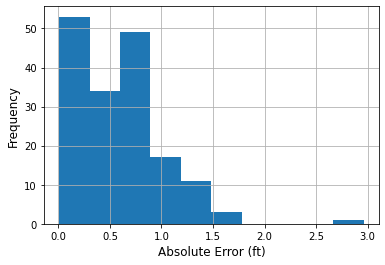

In [43]:
import matplotlib.pyplot as plt
jhist = joined.ErrorFt.hist()
plt.xlabel("Absolute Error (ft)", fontsize=12)
plt.ylabel("Frequency",fontsize=12)

Text(0, 0.5, 'Frequency')

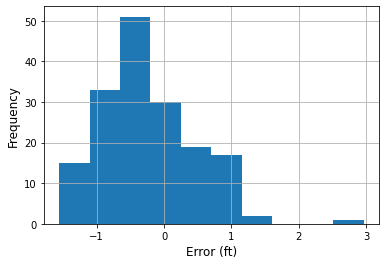

In [44]:
(joined["DSMElevation"] - joined["ELEVATION"]).hist()
plt.xlabel("Error (ft)", fontsize=12)
plt.ylabel("Frequency",fontsize=12)